In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- 1. Data Generation ---
def generate_server_data(num_servers=500, seed=42):
    """
    Generates synthetic data for servers in a data center.
    Power consumption is correlated with x/y position and job type.
    """
    np.random.seed(seed) # for reproducibility

    # Server IDs
    server_ids = [f"server_{i+1:03d}" for i in range(num_servers)]

    # X and Y positions (e.g., on a 0-100 grid)
    x_positions = np.random.rand(num_servers) * 100
    y_positions = np.random.rand(num_servers) * 100

    # Job types
    job_types_categories = ['CPU_intensive', 'IO_intensive', 'Memory_intensive', 'Idle', 'Mixed_load']
    job_types = np.random.choice(job_types_categories, num_servers, p=[0.25, 0.2, 0.15, 0.1, 0.3])

    # Base power consumption
    base_power = 50  # Watts for an idle server

    # Power consumption calculation
    power_consumption = np.zeros(num_servers)
    for i in range(num_servers):
        # Job type effect
        job_effect = 0
        if job_types[i] == 'CPU_intensive':
            job_effect = 150 + np.random.normal(0, 15) # Higher power, some variance
        elif job_types[i] == 'IO_intensive':
            job_effect = 70 + np.random.normal(0, 10)
        elif job_types[i] == 'Memory_intensive':
            job_effect = 100 + np.random.normal(0, 12)
        elif job_types[i] == 'Mixed_load':
            job_effect = 120 + np.random.normal(0, 10)
        else: # Idle
            job_effect = np.random.normal(0, 5) # Small variance for idle

        # Positional effect (e.g., servers in a certain quadrant or area consume more)
        # Let's assume a "hot zone" if x > 50 and y > 50, or a gradient
        positional_effect = 0
        # Simple linear gradient from one corner to another
        positional_effect += (x_positions[i] / 100) * 30 # Max 30W effect from x
        positional_effect += (y_positions[i] / 100) * 20 # Max 20W effect from y

        # Interaction effect: e.g. certain job types are more sensitive to position
        interaction_effect = 0
        if job_types[i] == 'CPU_intensive' and x_positions[i] > 70:
            interaction_effect = 25 # Extra power for CPU intensive jobs in a specific x-region

        power_consumption[i] = base_power + job_effect + positional_effect + interaction_effect + np.random.normal(0, 8) # Add some random noise

    # Ensure power consumption is not negative
    power_consumption = np.maximum(power_consumption, 10) # Minimum 10W

    df = pd.DataFrame({
        'server_id': server_ids,
        'x_position': x_positions,
        'y_position': y_positions,
        'job_type': job_types,
        'power_consumption_kw': power_consumption / 1000 # Convert to kW
    })

    # Simulate some missing values (optional, to demonstrate handling)
    # Let's add a few NaNs to x_position and job_type for demonstration
    nan_indices_x = np.random.choice(df.index, size=int(num_servers * 0.02), replace=False)
    df.loc[nan_indices_x, 'x_position'] = np.nan

    nan_indices_job = np.random.choice(df.index, size=int(num_servers * 0.01), replace=False)
    df.loc[nan_indices_job, 'job_type'] = np.nan
    
    print("--- Data Generation Complete ---")
    print(f"Generated {len(df)} server records.")
    print(f"Sample data:\n{df.head()}\n")
    return df

In [3]:
# --- 2. Data Preprocessing and Cleaning ---
def preprocess_data(df):
    """
    Preprocesses the server data:
    - Defines features and target
    - Creates preprocessing pipelines for numerical and categorical data
    - Splits data into training and testing sets
    """
    print("--- Data Preprocessing and Cleaning ---")
    
    # Define features (X) and target (y)
    # server_id is an identifier, not a feature for the model
    X = df.drop(['power_consumption_kw', 'server_id'], axis=1)
    y = df['power_consumption_kw']

    # Identify numerical and categorical features
    numerical_features = ['x_position', 'y_position']
    categorical_features = ['job_type']

    # Create preprocessing pipelines for numerical and categorical data
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')), # Fill missing numerical values with median
        ('scaler', StandardScaler()) # Scale numerical features
    ])

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')), # Fill missing categorical values with mode
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
    ])

    # Create a column transformer to apply different transformations to different columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_features),
            ('cat', categorical_pipeline, categorical_features)
        ],
        remainder='passthrough' # Keep other columns (if any)
    )

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
    print("Missing values before preprocessing (training set):")
    print(X_train.isnull().sum())
    
    # Fit the preprocessor on training data and transform both training and test data
    # This is usually done as part of the main model pipeline, but we can show it here
    # For demonstration, let's fit and transform X_train to see the effect
    X_train_processed_temp = preprocessor.fit_transform(X_train)
    print(f"\nShape of X_train after preprocessing: {X_train_processed_temp.shape}")
    # Note: The actual fitting of the preprocessor will happen within the main pipeline during model training.

    print("Preprocessing setup complete.\n")
    return X_train, X_test, y_train, y_test, preprocessor

In [4]:
# --- 3. Modeling ---
def train_and_evaluate_model(X_train, X_test, y_train, y_test, preprocessor):
    """
    Trains a RandomForestRegressor model and evaluates its performance.
    """
    print("--- Model Training and Evaluation ---")

    # Create the full pipeline: preprocessor + model
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True, n_jobs=-1, max_depth=10, min_samples_split=5))
    ])

    # Train the model
    print("Training the RandomForestRegressor model...")
    model.fit(X_train, y_train)
    print("Model training complete.")

    # Evaluate the model
    # Out-of-Bag Score (from training)
    if hasattr(model.named_steps['regressor'], 'oob_score_') and model.named_steps['regressor'].oob_score_:
         print(f"Out-of-Bag R^2 score: {model.named_steps['regressor'].oob_score_:.4f}")

    # Predictions on the test set
    y_pred = model.predict(X_test)

    # Performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nModel Performance on Test Set:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2) Score: {r2:.4f}\n")
    
    return model, y_pred

In [5]:
# --- 4. Interpretation and Discovery ---
def interpret_and_discover(model, X_train, df_original):
    """
    Provides interpretation of the model and some data discovery insights.
    """
    print("--- Model Interpretation and Discovery ---")

    # Feature Importances (from RandomForestRegressor)
    try:
        # Get feature names after one-hot encoding
        onehot_encoder = model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
        categorical_feature_names = list(onehot_encoder.get_feature_names_out(['job_type']))
        
        numerical_features = ['x_position', 'y_position'] # From preprocessing step
        
        # Combine all feature names in the correct order
        # Order depends on ColumnTransformer: first numerical, then categorical
        all_feature_names = numerical_features + categorical_feature_names
        
        importances = model.named_steps['regressor'].feature_importances_
        feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        print("Feature Importances:")
        print(feature_importance_df)

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10)) # Top 10
        plt.title('Top Feature Importances')
        plt.tight_layout()
        plt.savefig("feature_importances.png") # Save for review
        print("\nFeature importance plot saved as feature_importances.png")
        # plt.show() # Uncomment if running in an environment that supports interactive plots

    except Exception as e:
        print(f"Could not extract feature importances: {e}")


    # Correlation Analysis (on the original, pre-processed numerical data)
    print("\nCorrelation Matrix (Original Numerical Features vs Target):")
    # Select only original numerical columns and the target for a simple correlation view
    # We need to handle NaNs for correlation calculation
    df_for_corr = df_original[['x_position', 'y_position', 'power_consumption_kw']].copy()
    df_for_corr.dropna(inplace=True) # Drop rows with NaNs for this specific correlation

    if not df_for_corr.empty:
        correlation_matrix = df_for_corr.corr()
        print(correlation_matrix)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Matrix of Numerical Features and Target')
        plt.tight_layout()
        plt.savefig("correlation_matrix.png")
        print("\nCorrelation matrix plot saved as correlation_matrix.png")
        # plt.show() # Uncomment for interactive display
    else:
        print("Not enough data for correlation matrix after dropping NaNs.")

    # Scatter plot of a key feature vs target
    plt.figure(figsize=(8, 6))
    # Use original data for plotting, handling NaNs
    sns.scatterplot(x=df_original['x_position'].dropna(), y=df_original['power_consumption_kw'].dropna(), alpha=0.5)
    plt.title('Power Consumption vs X Position')
    plt.xlabel('X Position')
    plt.ylabel('Power Consumption (kW)')
    plt.tight_layout()
    plt.savefig("power_vs_x_position.png")
    print("\nScatter plot (Power vs X Position) saved as power_vs_x_position.png")
    # plt.show()

    # Scatter plot of actual vs predicted values
    # This requires y_test and y_pred from the modeling step, so it might be better placed there
    # or passed as arguments if we want to keep this function separate.
    # For now, let's assume we'd call this after getting predictions.
    print("\nTo visualize model predictions: Plot Actual vs. Predicted values (requires y_test, y_pred).")


In [9]:
print("Starting End-to-End Machine Learning Workflow for Data Center Power Consumption\n")
# 1. Generate Data
server_df = generate_server_data(num_servers=500)
server_df.head()

Starting End-to-End Machine Learning Workflow for Data Center Power Consumption

--- Data Generation Complete ---
Generated 500 server records.
Sample data:
    server_id  x_position  y_position          job_type  power_consumption_kw
0  server_001   37.454012   69.816171     CPU_intensive              0.206036
1  server_002   95.071431   53.609637  Memory_intensive              0.159405
2  server_003   73.199394   30.952762        Mixed_load              0.227894
3  server_004   59.865848   81.379502        Mixed_load              0.222590
4  server_005   15.601864   68.473117        Mixed_load              0.201150



,server_id,x_position,y_position,job_type,power_consumption_kw
0,server_001,37.454012,69.816171,CPU_intensive,0.206036
1,server_002,95.071431,53.609637,Memory_intensive,0.159405
2,server_003,73.199394,30.952762,Mixed_load,0.227894
3,server_004,59.865848,81.379502,Mixed_load,0.222590
4,server_005,15.601864,68.473117,Mixed_load,0.201150


In [10]:
# 2. Preprocess Data
X_train, X_test, y_train, y_test, preprocessor_pipeline = preprocess_data(server_df.copy()) # Use a copy to keep original df intact

--- Data Preprocessing and Cleaning ---
X_train shape: (400, 3), X_test shape: (100, 3)
y_train shape: (400,), y_test shape: (100,)
Missing values before preprocessing (training set):
x_position    9
y_position    0
job_type      4
dtype: int64

Shape of X_train after preprocessing: (400, 7)
Preprocessing setup complete.



--- Model Training and Evaluation ---
Training the RandomForestRegressor model...
Model training complete.
Out-of-Bag R^2 score: 0.8770

Model Performance on Test Set:
Mean Squared Error (MSE): 0.0003
R-squared (R2) Score: 0.8700

--- Model Interpretation and Discovery ---
Feature Importances:
                     feature  importance
4              job_type_Idle    0.571167
2     job_type_CPU_intensive    0.164371
3      job_type_IO_intensive    0.111675
0                 x_position    0.092401
1                 y_position    0.040962
6        job_type_Mixed_load    0.010852
5  job_type_Memory_intensive    0.008572

Feature importance plot saved as feature_importances.png

Correlation Matrix (Original Numerical Features vs Target):
                      x_position  y_position  power_consumption_kw
x_position              1.000000    0.013704              0.141351
y_position              0.013704    1.000000              0.141187
power_consumption_kw    0.141351    0.141187             

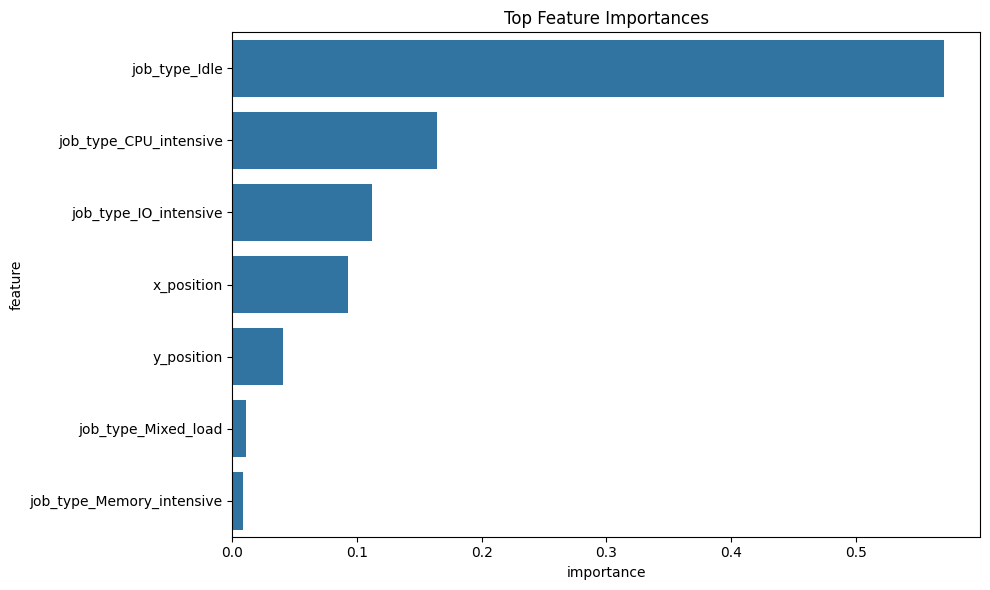

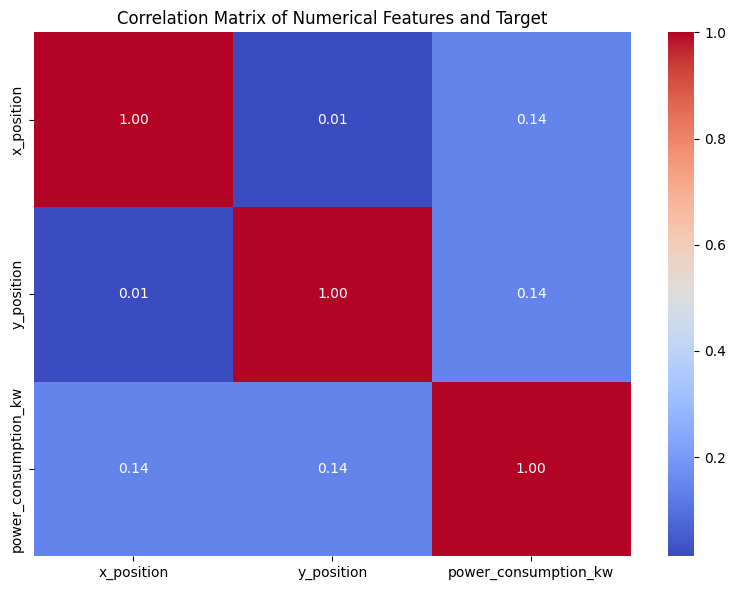

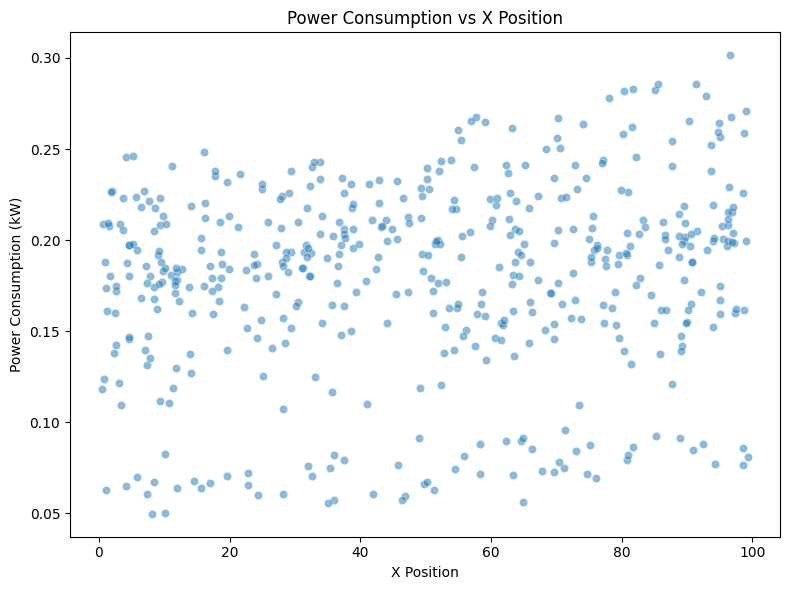

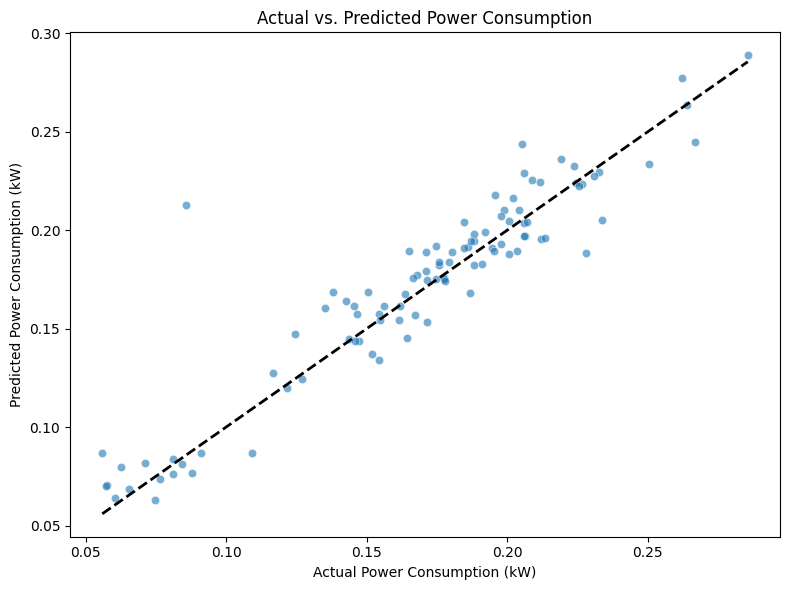

In [11]:
trained_model, y_predictions = train_and_evaluate_model(X_train, X_test, y_train, y_test, preprocessor_pipeline)

# 4. Interpret and Discover
# Pass the trained model pipeline and the original X_train (or full X for context if needed for feature names)
# Also pass the original dataframe for broader data discovery like correlations
interpret_and_discover(trained_model, X_train, server_df.copy())

# Example: Plotting actual vs predicted (can be part of interpret_and_discover or here)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_predictions, alpha=0.6, edgecolors='w', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
plt.xlabel('Actual Power Consumption (kW)')
plt.ylabel('Predicted Power Consumption (kW)')
plt.title('Actual vs. Predicted Power Consumption')
plt.tight_layout()
plt.savefig("actual_vs_predicted.png")
print("\nActual vs. Predicted plot saved as actual_vs_predicted.png")
plt.show()

In [ ]:

# 3. Train and Evaluate Model
# Ensure y_train and y_test are not empty or all NaNs before training
if y_train.isnull().all() or y_test.isnull().all():
    print("Error: Target variable (y_train or y_test) contains all NaNs. Check data generation and preprocessing.")
elif len(y_train) == 0 or len(y_test) == 0:
        print("Error: Training or testing set is empty. Check data splitting.")
else:
    trained_model, y_predictions = train_and_evaluate_model(X_train, X_test, y_train, y_test, preprocessor_pipeline)

    # 4. Interpret and Discover
    # Pass the trained model pipeline and the original X_train (or full X for context if needed for feature names)
    # Also pass the original dataframe for broader data discovery like correlations
    interpret_and_discover(trained_model, X_train, server_df.copy())

    # Example: Plotting actual vs predicted (can be part of interpret_and_discover or here)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_predictions, alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
    plt.xlabel('Actual Power Consumption (kW)')
    plt.ylabel('Predicted Power Consumption (kW)')
    plt.title('Actual vs. Predicted Power Consumption')
    plt.tight_layout()
    plt.savefig("actual_vs_predicted.png")
    print("\nActual vs. Predicted plot saved as actual_vs_predicted.png")
    plt.show()